In [1]:
import math
import random
import numpy as np
import torch 
import torch.optim as optim
import torch.nn as nn
from copy import deepcopy
import asyncio
import nest_asyncio
from HP2D_Env import HP2D
from lattice2d_linear_env import Lattice2DLinearEnv
from MCTS import MCTS
from MCTS_RNN import MCTS_RNN, MCTSNode
from models import RNN, GRUNet
from tqdm import tqdm
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
nest_asyncio.apply()

In [2]:
USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Using GPU: GPU requested and available.")
    dtype = torch.cuda.FloatTensor
    dtypelong = torch.cuda.LongTensor
else:
    print("NOT Using GPU: GPU not requested or not available.")
    dtype = torch.FloatTensor
    dtypelong = torch.LongTensor

Using GPU: GPU requested and available.


In [3]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, prob, value):
        self.buffer.append((state, prob, value))

    def sample(self, batch_size):
        state, prob, value = zip(*random.sample(self.buffer, batch_size))
        return state, prob, value

    def __len__(self):
        return len(self.buffer)
    
replay_size = 60000
replay_buffer = ReplayBuffer(replay_size)

In [4]:
rnn = RNN(10, 4, 11, 128, USE_CUDA)
gru = GRUNet(10, 4, 128, USE_CUDA)

if USE_CUDA:
    rnn = rnn.cuda()
    gru = gru.cuda()

In [5]:
class AlphaLoss(nn.Module):
    def __init__(self):
        super(AlphaLoss, self).__init__()
        
    def forward(self, pred_v, v, pred_p, p):
        ve = nn.MSELoss(reduction = 'none')
        v_err = ve(pred_v.view(-1), v)
        p_err = torch.sum((-p * (1e-15 + pred_p).log()), dim = 1)
        tot_err = (v_err + p_err).mean()
        return tot_err

In [6]:
def compute_loss(net, batch_size, replay_buffer, optimizer, criterion):
    state, p, v = replay_buffer.sample(batch_size)
    state = torch.tensor(np.float32(state)).type(dtype)
    p = torch.tensor(np.float32(p)).type(dtype)
    v = torch.tensor(v).type(dtype)
    
    hidden = net.init_hidden()
    hidden = torch.tensor(np.float32(hidden)).type(dtype)
    optimizer.zero_grad()
    
    
    for i in range(state[0].size()[0]):
        pred_p, pred_v, hidden = net(state[0][i].unsqueeze(0), hidden)
        
    loss = criterion(pred_v, v, pred_p, p)
    loss.backward()
    optimizer.step()
    return loss

In [7]:
file = open('seqs.txt', 'r')
seq_list = file.readlines()
max_length = 5
# Get sequences with length <= max_length
seqs = [s for s in seq_list if len(s) <= max_length + 1]
test_seqs = random.sample(seqs, len(seqs) // 10)
train_seqs = [s for s in seqs if s not in test_seqs]

# Pretrain

In [8]:
# Fill replay buffer (training on sequences with length <= 15)
ss = [s for s in seq_list if len(s) <= 6]
for seq in tqdm(ss):
    root = MCTSNode(())
    mcts = MCTS_RNN(seq[:-1], 300, (10,11,11))
    mcts.get_prob(root)
    data = mcts.get_data(root)
    for i in range(len(data)):
        replay_buffer.push(data[i][0], data[i][1], data[i][2])

100%|██████████| 48/48 [00:08<00:00,  5.54it/s]


In [9]:
# Train using pregenerated data, not neural net MCTS
criterion = AlphaLoss()
optimizer = optim.Adam(rnn.parameters(), lr = 0.001)
gru_losses = []

# 10000 Epochs, 10 updates per epoch, batch size 32
for ts in tqdm(range(10000)):
    if len(replay_buffer) >= 1:
        loss = compute_loss(gru, 1, replay_buffer, optimizer, criterion)
        gru_losses.append(loss)

100%|██████████| 10000/10000 [01:52<00:00, 89.15it/s]


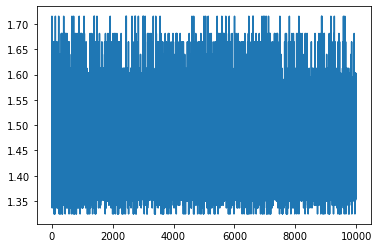

In [10]:
plt.plot(gru_losses)

In [11]:
# Train using pregenerated data, not neural net MCTS
criterion = AlphaLoss()
optimizer = optim.Adam(rnn.parameters(), lr = 0.001)
rnn_losses = []

# 10000 Epochs, 10 updates per epoch, batch size 32
for ts in tqdm(range(10000)):
    if len(replay_buffer) >= 1:
        loss = compute_loss(rnn, 1, replay_buffer, optimizer, criterion)
        rnn_losses.append(loss)

100%|██████████| 10000/10000 [02:41<00:00, 61.78it/s]


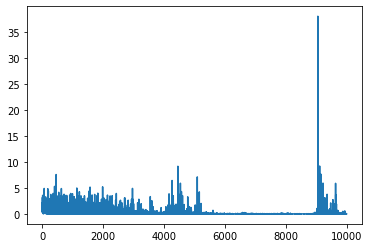

In [12]:
plt.plot(rnn_losses)